# Read the Forces from a QBOX Output
Just to make sure the ASE parser is working

In [1]:
%matplotlib inline
from ase.io import qbox, cube
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import itertools
import os

## Read in an OUTPUT file
Pick one at random

In [2]:
data = qbox.read_out(os.path.join('256_Al', 'kpgenlong_sd_psd_combo_r17_111_cutoff_50_3.out'), slice(None))

In [3]:
print('Read %d frames'%len(data))

Read 800 frames


## Plot Energy as a Function of Frame
Simple plot

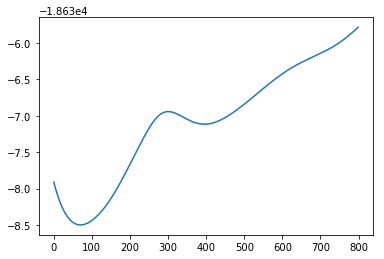

In [4]:
fig, ax = plt.subplots()

ax.plot(range(len(data)), [frame.get_total_energy() for frame in data])

## Plot Force on H as a function of position
This should be equivalent to the plot in the paper

In [5]:
forces = [frame.get_forces()[-1] for frame in data]
position = [frame[-1].position for frame in data]

Compute the displacement and magnitude of force

In [6]:
force_mag = [x[0] for x in forces]
displacement = [norm(x-position[0]) for x in position]

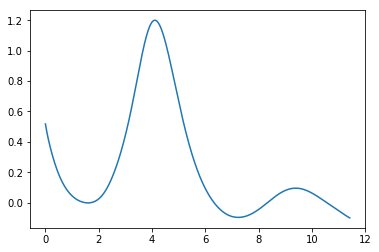

In [7]:
fig, ax = plt.subplots()

ax.plot(displacement, force_mag)

## Read the CUBE file
Load in the file using `ase`, make in an interpolator

In [8]:
density, cube_atoms = cube.read_cube_data(os.path.join('256_Al', 'Al_semi_core_gs.cube'))

Plot the yz plane

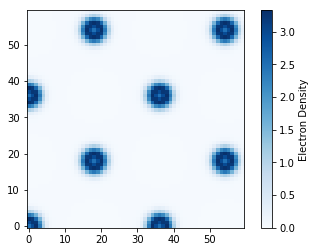

In [9]:
fig, ax = plt.subplots()

cbdata = ax.imshow(density[0,:60,:60], cmap='Blues', vmin=0, vmax=density.max(), origin='lower')

fig.colorbar(cbdata, label='Electron Density')

Functions for getting an interpolator (from `b2-test`)

In [10]:
def expand_density(rho):
    """Density from CUBE is on range [0,1) along each axis, make it go from [0,1]
    
    Do so by appending the data at '0' to that at 1 (periodic boundary conditions)"""
    
    # Make a slightly larger array
    rho_new = np.zeros(np.array(rho.shape)+1)
    
    # Copy over the data
    rho_new[:rho.shape[0], :rho.shape[1], :rho.shape[2]] = rho # Bulk of the data
    
    rho_new[:rho.shape[0], :rho.shape[1], rho.shape[2]] = rho[:,:,0] # Faces
    rho_new[:rho.shape[0], rho.shape[1], :rho.shape[2]] = rho[:,0,:]
    rho_new[rho.shape[0], :rho.shape[1], :rho.shape[2]] = rho[0,:,:]
    
    rho_new[:rho.shape[0], rho.shape[1], rho.shape[2]] = rho[:,0,0] # Edges
    rho_new[rho.shape[0], :rho.shape[1], rho.shape[2]] = rho[0,:,0] 
    rho_new[rho.shape[0], rho.shape[1], :rho.shape[2]] = rho[0,0,:]
    
    rho_new[rho.shape[0], rho.shape[1], rho.shape[2]] = rho[0,0,0] # Point
    
    return rho_new
def get_interpolator(cd):
    """Downsample a charge car to a certain number of samples. 
    
    :return: ndarray with the requested number of samples"""
    
    # Expand the array to go between zero and one
    charge = expand_density(cd)
    
    # Grid varies between [0,1)
    return RegularGridInterpolator([list(np.linspace(0,1,x)) for x in charge.shape], charge)

In [11]:
density_inter = get_interpolator(density)

## Plot force vs local density
Just to see if the two are indeed correlated

In [12]:
scaled_pos = [frame.get_scaled_positions()[-1] for frame in data]

In [13]:
path_density = density_inter(scaled_pos)

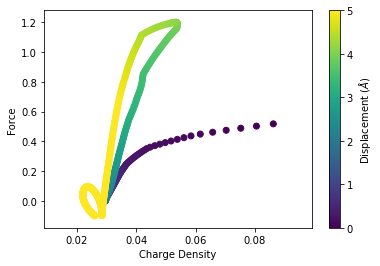

In [14]:
fig, ax = plt.subplots()

cbdata = ax.scatter(path_density, force_mag, c=displacement, vmax=5)

fig.colorbar(cbdata, label='Displacement ($\AA$)')

ax.set_xlabel('Charge Density')
ax.set_ylabel('Force')